In [188]:
import numpy as np
import pandas as pd
import cv2
import pytesseract
import spacy
import re
import string
import matplotlib.pyplot as plt
from glob import glob

In [189]:
def show_img(img):
    fig = plt.gcf()
    fig.set_size_inches(16, 8)
    plt.axis(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [190]:
def clean_text(txt):
    whitespace = string.whitespace
    punctuation = "!#$%&\'()*+:;<=>?[\\]^`{|}~"
    table_whitespace = str.maketrans('', '', whitespace)
    table_punctuation = str.maketrans('', '', punctuation)
    
    text = str(txt)
    text = text.lower()
    remove_whitespace = text.translate(table_whitespace)
    remove_punctuation = remove_whitespace.translate(table_punctuation)
    
    return str(remove_punctuation)

In [191]:
### Load NER Model
model_ner = spacy.load('output/model-best/')

/Volumes/STARLAI/Developments/PyCharmProject/Document Scanner/.venv/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.1.3 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [192]:
# Load Image
image = cv2.imread('data/6.jpg')

# Extract OCR
tess_data = pytesseract.image_to_data(image)

# Convert into dataframe
tess_list = list(map(lambda x: x.split('\t'), tess_data.split('\n')))
df = pd.DataFrame(tess_list[1:], columns=tess_list[0])
df.dropna(inplace=True)
df['text'] = df['text'].apply(clean_text)

# Convert data into content
df_clean = df.query('text != ""')
content = " ".join([ w for w in df_clean['text']])

# Get prediction from NER model
doc = model_ner(content)


In [193]:
from spacy import displacy
# displacy.serve(doc, style='ent', port=5123)

In [194]:
displacy.render(doc, style='ent')

## Tagging

In [195]:
doc_json = doc.to_json()
doc_json.keys()

dict_keys(['text', 'ents', 'tokens'])

In [196]:
doc_json['ents']

[{'start': 5, 'end': 15, 'label': 'B-PHONE'},
 {'start': 19, 'end': 29, 'label': 'B-PHONE'},
 {'start': 36, 'end': 57, 'label': 'B-EMAIL'},
 {'start': 58, 'end': 62, 'label': 'B-ORG'},
 {'start': 63, 'end': 72, 'label': 'I-ORG'},
 {'start': 73, 'end': 84, 'label': 'I-ORG'},
 {'start': 85, 'end': 87, 'label': 'I-ORG'},
 {'start': 88, 'end': 93, 'label': 'I-ORG'},
 {'start': 94, 'end': 116, 'label': 'B-EMAIL'},
 {'start': 117, 'end': 127, 'label': 'B-NAME'},
 {'start': 128, 'end': 136, 'label': 'I-NAME'},
 {'start': 137, 'end': 146, 'label': 'B-DES'},
 {'start': 147, 'end': 154, 'label': 'I-DES'},
 {'start': 179, 'end': 183, 'label': 'B-ORG'},
 {'start': 184, 'end': 193, 'label': 'I-ORG'},
 {'start': 194, 'end': 205, 'label': 'I-ORG'},
 {'start': 206, 'end': 208, 'label': 'I-ORG'},
 {'start': 209, 'end': 214, 'label': 'I-ORG'},
 {'start': 306, 'end': 339, 'label': 'I-WEB'},
 {'start': 341, 'end': 374, 'label': 'B-WEB'}]

In [197]:
doc_text = doc_json['text']
doc_text

'cell 8099948528 ga 8466045457 email lictsrikant@gmail.com life insurance corporation of india seosrikantht@gmail.com thathineni srikanth insurance advisor agent code no. 0316164y life insurance corporation of india br. off. lic office, trimulgherry, sec’bad - 500 016. add. borabanda, hyderabad - 500 018. lictsrikant8099948528.blogspot.in, interviewsinhyderabad.blogspot.in facebook.com/lictsrikant8099948528, facebook.com/thathineni.srikanth.9 promote your business online pybo'

In [198]:
df_tokens = pd.DataFrame(doc_json['tokens'])
df_tokens['token'] = df_tokens[['start', 'end']].apply(lambda x: doc_text[x[0]:x[1]], axis=1)
df_tokens.head(10)

/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/3097230.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_tokens['token'] = df_tokens[['start', 'end']].apply(lambda x: doc_text[x[0]:x[1]], axis=1)


,id,start,end,token
0,0,0,4,cell
1,1,5,15,8099948528
2,2,16,18,ga
3,3,19,29,8466045457
4,4,30,35,email
5,5,36,57,lictsrikant@gmail.com
6,6,58,62,life
7,7,63,72,insurance
8,8,73,84,corporation
9,9,85,87,of


In [199]:
doc_text[73:84]

'corporation'

In [200]:
right_table = pd.DataFrame(doc_json['ents'])[['start', 'label']]
df_tokens = pd.merge(df_tokens, right_table,how='left',on='start')
df_tokens.head(10)

,id,start,end,token,label
0,0,0,4,cell,NaN
1,1,5,15,8099948528,B-PHONE
2,2,16,18,ga,NaN
3,3,19,29,8466045457,B-PHONE
4,4,30,35,email,NaN
5,5,36,57,lictsrikant@gmail.com,B-EMAIL
6,6,58,62,life,B-ORG
7,7,63,72,insurance,I-ORG
8,8,73,84,corporation,I-ORG
9,9,85,87,of,I-ORG


In [201]:
df_tokens.fillna('O', inplace=True)
df_tokens.head(10)

,id,start,end,token,label
0,0,0,4,cell,O
1,1,5,15,8099948528,B-PHONE
2,2,16,18,ga,O
3,3,19,29,8466045457,B-PHONE
4,4,30,35,email,O
5,5,36,57,lictsrikant@gmail.com,B-EMAIL
6,6,58,62,life,B-ORG
7,7,63,72,insurance,I-ORG
8,8,73,84,corporation,I-ORG
9,9,85,87,of,I-ORG


In [202]:
# Join label to df_clean
df_clean['end'] = df_clean['text'].apply(lambda x: len(x) + 1).cumsum() - 1
df_clean['start'] = df_clean[['text', 'end']].apply(lambda x: x[1] - len(x[0]), axis=1)

/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/2840440618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['end'] = df_clean['text'].apply(lambda x: len(x) + 1).cumsum() - 1
/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/2840440618.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_clean['start'] = df_clean[['text', 'end']].apply(lambda x: x[1] - len(x[0]), axis=1)
/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/2840440618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [203]:
# inner join with start
df_info = pd.merge(df_clean, df_tokens[['start', 'token', 'label']], how='inner', on='start')

In [204]:
df_info.head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,end,start,token,label
0,5,1,3,1,1,1,722,53,64,28,93.027191,cell,4,0,cell,O
1,5,1,3,1,1,3,822,53,203,28,96.644051,8099948528,15,5,8099948528,B-PHONE
2,5,1,3,2,1,1,55,55,85,89,47.185547,ga,18,16,ga,O
3,5,1,3,2,1,2,822,95,203,28,96.643845,8466045457,29,19,8466045457,B-PHONE
4,5,1,3,2,2,1,593,136,93,25,89.289780,email,35,30,email,O


## Bounding Box

In [205]:
bb_df = df_info.query('label != "O"')
bb_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,end,start,token,label
1,5,1,3,1,1,3,822,53,203,28,96.644051,8099948528,15,5,8099948528,B-PHONE
3,5,1,3,2,1,2,822,95,203,28,96.643845,8466045457,29,19,8466045457,B-PHONE
5,5,1,3,2,2,3,709,136,316,31,86.249245,lictsrikant@gmail.com,57,36,lictsrikant@gmail.com,B-EMAIL
6,5,1,3,3,1,1,46,170,33,14,96.406654,life,62,58,life,B-ORG
7,5,1,3,3,1,2,85,151,92,42,95.806709,insurance,72,63,insurance,I-ORG
8,5,1,3,3,1,3,183,170,117,14,96.909721,corporation,84,73,corporation,I-ORG
9,5,1,3,3,1,4,306,170,20,14,96.172005,of,87,85,of,I-ORG
10,5,1,3,3,1,5,332,170,42,14,96.796776,india,93,88,india,I-ORG
11,5,1,3,3,1,6,668,163,357,46,91.289627,seosrikantht@gmail.com,116,94,seosrikantht@gmail.com,B-EMAIL
12,5,1,4,1,1,1,310,228,232,30,92.664276,thathineni,127,117,thathineni,B-NAME


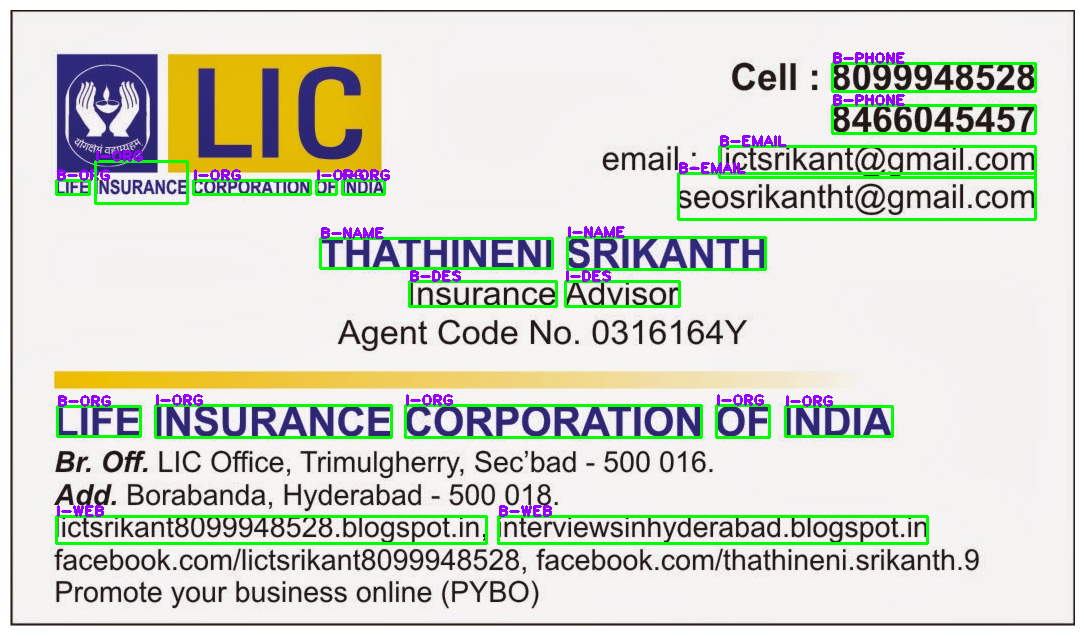

In [206]:
img = image.copy()

for x, y, w, h, label in bb_df[['left', 'top', 'width', 'height', 'label']].values:
    x, y, w, h = int(x), int(y), int(w), int(h)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, str(label), (x, y), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 150), 2)
    
show_img(img)

In [207]:
bb_df['label'] = bb_df['label'].apply(lambda x: x[2:])
bb_df.head()


/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/2006908084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['label'] = bb_df['label'].apply(lambda x: x[2:])


,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,end,start,token,label
1,5,1,3,1,1,3,822,53,203,28,96.644051,8099948528,15,5,8099948528,PHONE
3,5,1,3,2,1,2,822,95,203,28,96.643845,8466045457,29,19,8466045457,PHONE
5,5,1,3,2,2,3,709,136,316,31,86.249245,lictsrikant@gmail.com,57,36,lictsrikant@gmail.com,EMAIL
6,5,1,3,3,1,1,46,170,33,14,96.406654,life,62,58,life,ORG
7,5,1,3,3,1,2,85,151,92,42,95.806709,insurance,72,63,insurance,ORG


In [208]:
# group the label
class GroupGen:
    def __init__(self):
        self.id = 0
        self.text = ''
    
    def get_group(self, text):
        if self.text == text:
            return self.id
        else:
            self.id += 1
            self.text = text
            return self.id

ggen = GroupGen()

In [209]:
bb_df['group'] = bb_df['label'].apply(ggen.get_group)

/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/1896851862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['group'] = bb_df['label'].apply(ggen.get_group)


In [210]:
# right and bottom of bounding box
bb_df[['left', 'top', 'width', 'height']] = bb_df[['left', 'top', 'width', 'height']].astype(int)
bb_df['right'] = bb_df['left'] + bb_df['width']
bb_df['bottom'] = bb_df['top'] + bb_df['height']

/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/4192345427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df[['left', 'top', 'width', 'height']] = bb_df[['left', 'top', 'width', 'height']].astype(int)
/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/4192345427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['right'] = bb_df['left'] + bb_df['width']
/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/4192345427.py:4: SettingWithCopyWarning: 
A v

In [211]:
bb_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,end,start,token,label,group,right,bottom
1,5,1,3,1,1,3,822,53,203,28,96.644051,8099948528,15,5,8099948528,PHONE,1,1025,81
3,5,1,3,2,1,2,822,95,203,28,96.643845,8466045457,29,19,8466045457,PHONE,1,1025,123
5,5,1,3,2,2,3,709,136,316,31,86.249245,lictsrikant@gmail.com,57,36,lictsrikant@gmail.com,EMAIL,2,1025,167
6,5,1,3,3,1,1,46,170,33,14,96.406654,life,62,58,life,ORG,3,79,184
7,5,1,3,3,1,2,85,151,92,42,95.806709,insurance,72,63,insurance,ORG,3,177,193
8,5,1,3,3,1,3,183,170,117,14,96.909721,corporation,84,73,corporation,ORG,3,300,184
9,5,1,3,3,1,4,306,170,20,14,96.172005,of,87,85,of,ORG,3,326,184
10,5,1,3,3,1,5,332,170,42,14,96.796776,india,93,88,india,ORG,3,374,184
11,5,1,3,3,1,6,668,163,357,46,91.289627,seosrikantht@gmail.com,116,94,seosrikantht@gmail.com,EMAIL,4,1025,209
12,5,1,4,1,1,1,310,228,232,30,92.664276,thathineni,127,117,thathineni,NAME,5,542,258


In [212]:
 # Tagging: group_by group
col_group = ['left', 'top', 'right', 'bottom', 'label', 'token', 'group']
group_tag_img = bb_df[col_group].groupby(by='group')

In [213]:
img_tagging = group_tag_img.agg({
    'left': min,
    'right': max,
    'top': min,
    'bottom': max,
    'label': np.unique,
    'token': lambda x: " ".join(x)
})

/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/491724015.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  img_tagging = group_tag_img.agg({
/var/folders/f_/2zfn3_7d3517bsf7r58t_s040000gn/T/ipykernel_50593/491724015.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  img_tagging = group_tag_img.agg({


In [214]:
img_tagging

,left,right,top,bottom,label,token
group,,,,,,
1,822,1025,53,123,[PHONE],8099948528 8466045457
2,709,1025,136,167,[EMAIL],lictsrikant@gmail.com
3,46,374,151,193,[ORG],life insurance corporation of india
4,668,1025,163,209,[EMAIL],seosrikantht@gmail.com
5,310,755,227,259,[NAME],thathineni srikanth
6,399,669,271,296,[DES],insurance advisor
7,47,882,395,427,[ORG],life insurance corporation of india
8,46,917,506,533,[WEB],lictsrikant8099948528.blogspot.in interviewsin...


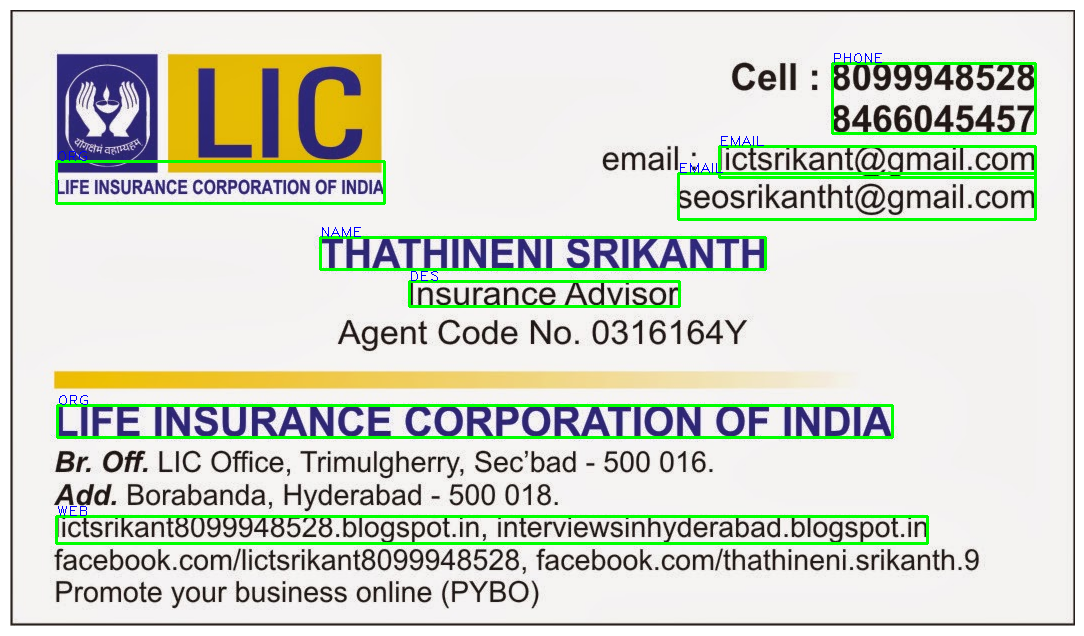

In [215]:
img_bb = image.copy()
for l, r, t, b, label, token in img_tagging.values:
    cv2.rectangle(img_bb, (l, t), (r, b), (0, 255, 0), 2)
    cv2.putText(img_bb, label[0], (l, t), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0))

show_img(img_bb)

## Parser

In [217]:
def parser(text, label):
    if label == 'PHONE':
        text = text.lower()
        text = re.sub(r'\D', '', text)
    elif label == 'EMAIL':
        text = text.lower()
        allow_chars = '@_.\-'
        text = re.sub(r'[^A-Za-z0-9{}]'.format(allow_chars), '', text)
    elif label == 'WEB':
        text = text.lower()
        allow_chars = ':/.%#\-'
        text = re.sub(r'[^A-Za-z0-9{}]'.format(allow_chars), '', text)
    elif label in ('NAME', 'DES'):
        text = text.lower()
        text = re.sub(r'[^a-z]', '', text)
        text = text.title()
    elif label == 'ORG':
        text = text.lower()
        text = re.sub(r'[^a-z0-9]', '', text)
        text = text.title()
    return text


In [219]:
parser('Maranata 293293', 'NAME')

'Maranata'

In [221]:
parser('(#$#$)mama123@gmail.com', 'EMAIL')

'mama123@gmail.com'

## Entities

In [227]:
info_arr = df_info[['token', 'label']].values
entities = dict(NAME=[], ORG=[], DES=[], PHONE=[], EMAIL=[], WEB=[])
previous = 'O'

for token, label in info_arr:
    bio_tag = label[0]
    label_tag = label[2:]
    
    text = parser(token, label_tag)
    
    if bio_tag in ('B', 'I'):
        if previous != label_tag:
            entities[label_tag].append(text)
        else:
            if bio_tag == 'B':
                entities[label_tag].append(text)
            else:
                if label_tag in ("NAME", "ORG", "DES"):
                    entities[label_tag][-1] = entities[label_tag][-1] + " " + text
                else:
                    entities[label_tag][-1] = entities[label_tag][-1] + text
    previous = label_tag

In [228]:
print(entities)

{'NAME': ['Thathineni Srikanth'], 'ORG': ['Life Insurance Corporation Of India', 'Life Insurance Corporation Of India'], 'DES': ['Insurance Advisor'], 'PHONE': ['8099948528', '8466045457'], 'EMAIL': ['lictsrikant@gmail.com', 'seosrikantht@gmail.com'], 'WEB': ['lictsrikant8099948528.blogspot.in', 'interviewsinhyderabad.blogspot.in']}
